# Analysis of Microarray & Microtiter plates
Analysis of peptide-virus binding signals.

This notebook provides simple visualisation and analysis functions to work with experimental data sets from the FluType project.

In [78]:
# TODO: larger axes & bold
# TODO: correlation plot

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import normalize
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.colors as colors

# import string
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.mplot3d import Axes3D
# import pyexcel 
# import json

## Load dataset for analysis
Here the different data sets are loaded and brought in a common standard format for the analysis pipeline.

In [193]:
from IPython.display import display, HTML
data_ids = {'2017-05-12_MTP_R1', 'flutype_test' }

#--------------------------
data_id = '2017-05-12_MTP_R1'
#data_id = 'flutype_test'
#--------------------------
if data_id == '2017-05-12_MTP_R1': 
    # Microtiter Plate (2017-05-12, 1 plate, 1/3 repeats)
    meta = pd.read_csv("data/{}.meta".format(data_id), sep='\t')
    output = pd.read_csv("data/{}.csv".format(data_id), sep=',', index_col=0)
    output = output.T
    
    # todo: this information has to be pulled out from data (in meta information for experiment)
    output.index = ["X31A","X31","X31","X31","Pan","Pan","Pan","Calif","Calif","Calif","no-virus","no-virus"]
    
elif data_id == "flutype_test":
    # Microarray (1 plate, 1 measurement)
    meta = pd.read_csv("data/{}.meta".format(data_id), sep='\t')
    output = pd.read_csv("data/{}.csv".format(data_id) , sep='\t')
    output.index = output.virus
    output = output.drop('virus', 1)
    

display(meta)
display(output.head())

,field,info
0,type,Microtiter Plate
1,date,2017-05-12
2,repeat,1
3,total_repeats,3
4,virus,"[""X31A"",""X31"",""X31"",""X31"",""Pan"",""Pan"",""Pan"",""C..."
5,peptides,?


,A,B,C,D,E,F,G,H
X31A,22508,21229,21266,21238,20484,14842,33306,17090
X31,20337,22922,23449,23548,24198,17464,37703,20670
X31,20394,21386,23071,26460,27889,17428,40646,22175
X31,18970,19488,20933,23260,25058,17656,39031,22479
Pan,17500,16958,18548,18157,18304,15398,27502,17905


## Heatmap of plate/chip

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


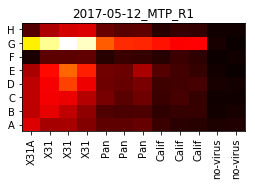

In [194]:
#heatmap of microwellplate
# legend (color bar)

data = output.convert_objects(convert_numeric=True)

fig = plt.figure(figsize=(4.0,2))
plt.pcolor(data.T,cmap='hot')
plt.xticks(np.arange(0.5, len(data.index), 1), output.index,rotation=90)
plt.yticks(np.arange(0.5, len(data.columns), 1), data.columns)
plt.title(data_id,fontsize="large")
fig.savefig("./results/{}_heatmap.png".format(data_id),bbox_inches='tight')

plt.show()


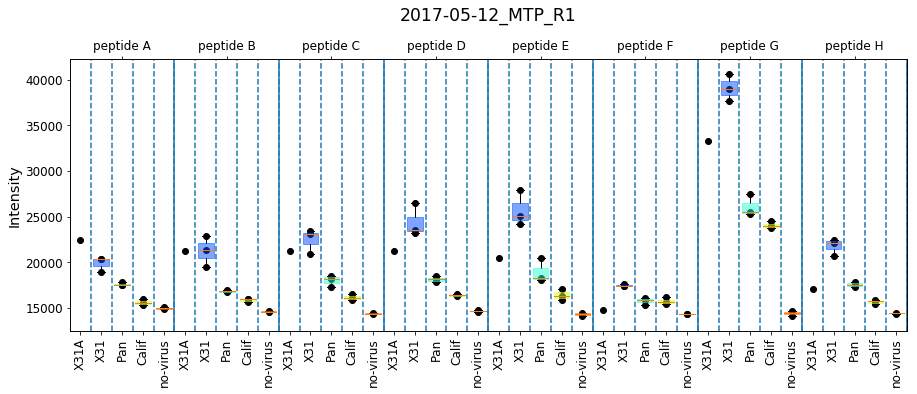

In [195]:
# overview plot of peptide-virus signal
fig = plt.figure(figsize=(15,5.0))
ax2 = plt.subplot(111)
ax = ax2.twiny()

# for x-axis ticks and labels
peptide_ticks_x_axis = []
virus_ticks_x_axis = []
virus_label_x_axis = []

cmap  = plt.get_cmap('jet')
Nvirus = len(output.index.unique())
spacing = 1.0/Nvirus

for index_peptide, peptide in enumerate(output.columns):
    for index_virus, virus in enumerate(output.index.unique()):
        
        #draw vertical dashed line to seperate viruses
        plt.axvline(x=[index_peptide + index_virus * spacing + spacing * 0.5 ], linestyle='dashed')
        
        # add x-tick position and label for virus
        virus_ticks_x_axis.append(index_peptide + index_virus * spacing)
        virus_label_x_axis.append(virus)
        
        # select data with current peptide and virus 
        data = output[peptide].where(output.index==virus)
        data = data.dropna(axis=0, how='all')
        
        # scatter plot (individual data points)
        ax.scatter(index_peptide  * np.ones(data.shape) + index_virus * spacing, data, color='k', marker='o')

        
        # plot  boxplot if more than one datapoint
        # what are whiskers?
        if len(data) > 1: 
            data = pd.to_numeric(data)
            bp = ax.boxplot(data.values, positions=[index_peptide+index_virus*spacing], 
                            patch_artist=True, showfliers=False)
            plt.setp(bp['boxes'], color=cmap(index_virus / Nvirus), alpha=0.5)
            

    # add x-tick position and label for peptide    
    peptide_ticks_x_axis.append(index_peptide + 0.4)
    
    #draw vertical line to seperate peptides
    plt.axvline(x=index_peptide + 1 - spacing * 0.5 )

# setup upper x-axis            
plt.xticks(peptide_ticks_x_axis,["peptide " + str(s) for s in output.columns],fontsize="large")
ax.set_xlim(-0.1 , index_peptide + 1 - spacing * 0.5 )

# setup lower x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(virus_ticks_x_axis)
#["peptide " + str(s) for s in output.columns]
ax2.set_xticklabels(virus_label_x_axis,rotation=90,fontsize="large")
ax2.tick_params(labelsize="large") 

ax2.set_ylabel("Intensity",fontsize="x-large")
# nicer plot
ax.set_title(data_id,y=1.12,fontsize="xx-large")
fig.savefig("./results/{}_barplot.png".format(data_id),bbox_inches='tight')

plt.show()

In [196]:
def map_strings_to_number(strings):
    """Transforms list of strings into numbers."""
    counter = 0
    d = {}
    numbers = []
    for s in strings:
        if s in d:
            pass
        else:
            d[s] = counter
            counter+=1
        numbers.append(d[s])
        
    return numbers
    
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a String or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for String, None, or a colormap instance:
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


In [197]:
#build model
pca = decomposition.PCA()
pca.fit(output)

#perform pca
pca_score = pca.explained_variance_ratio_ 
pca_components = pca.components_
x_train_pca = pca.transform(output)

output_pca = pd.DataFrame(x_train_pca, index=output.index, columns=output.columns)

# store color information
output_pca.insert(0, "color", map_strings_to_number(output.index))
output_pca.insert(1, "virus", output.index)

print("PCA score for principal components (explained variance):\n", pca_score.round(3))
corr_values = dict(zip(output.columns, pca_components[0]))
feature_max_cor = max(corr_values, key=corr_values.get)
print("Feature with max. Variation:",feature_max_cor )
print("PCA Components in feature space:", pca_components[0])


cor_to_strongest_feature = output[output.columns[:]].corr()[feature_max_cor][:]
print("\nThe Correlation of the Features to the Feature with highest Varaiance")
print(cor_to_strongest_feature)


PCA score for principal components (explained variance):
 [ 0.951  0.025  0.016  0.004  0.002  0.001  0.001  0.   ]
Feature with max. Variation: G
PCA Components in feature space: [ 0.18252918  0.22640689  0.26495517  0.32186458  0.36495278  0.08073223
  0.74204509  0.22646376]

The Correlation of the Features to the Feature with highest Varaiance
A    0.837000
B    0.910098
C    0.954515
D    0.961688
E    0.945932
F    0.831291
G    1.000000
H    0.928898
Name: G, dtype: float64


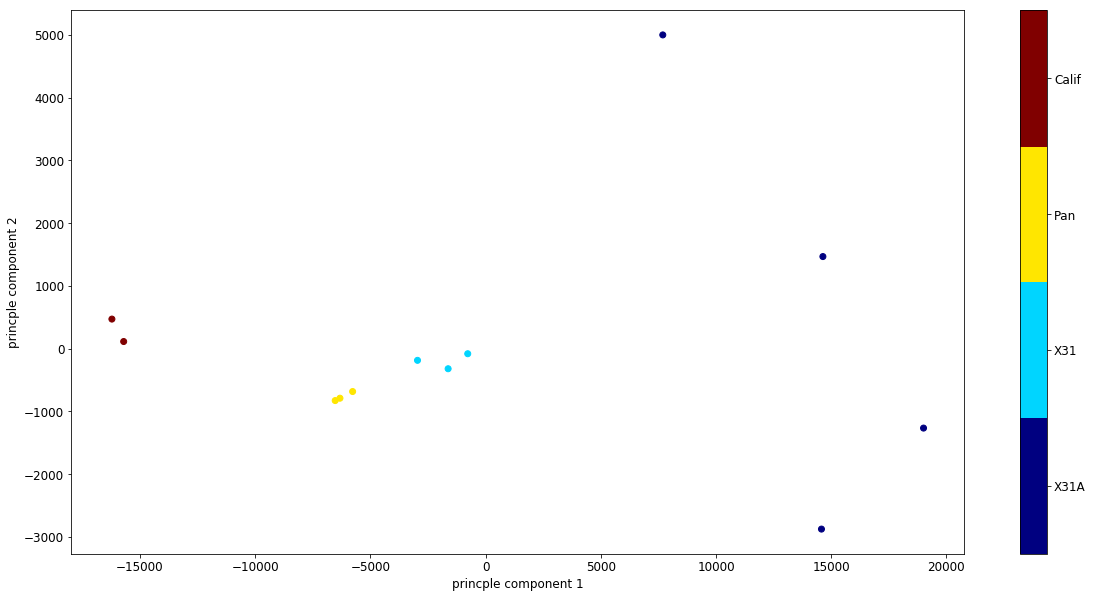

In [198]:
fig = plt.figure(figsize=(20, 10))
plt.xlabel("princple component 1",  size='large')
plt.ylabel("princple component 2",  size='large')
plt.tick_params(labelsize="large") 
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], 
            c=output_pca["color"].values, cmap=discrete_cmap(output_pca["color"].values.max(), 'jet'))



color_mapping = output_pca[['color','virus']].sort_values(by=["color"])


cbar = plt.colorbar(ticks=sorted(output_pca["color"].unique()))
cbar.set_ticklabels(color_mapping['virus'].unique())
cbar.ax.tick_params(labelsize="large") 
plt.clim(0.5, output_pca["color"].values.max() + 0.5)

plt.show()

In [199]:
from pandas.plotting import scatter_matrix


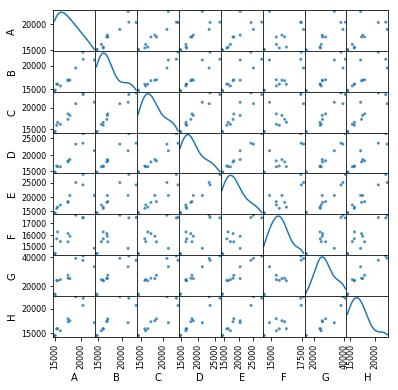

In [200]:
# TODO virus in color
scatter_matrix(output, alpha=0.8, figsize=(6, 6), diagonal='kde')
plt.show()

In [201]:
from matplotlib.collections import EllipseCollection

def plot_corr_ellipses(data, ax=None, **kwargs):

    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    if ax is None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'aspect':'equal'})
        ax.set_xlim(-0.5, M.shape[1] - 0.5)
        ax.set_ylim(-0.5, M.shape[0] - 0.5)

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel()
    h = 1 - np.abs(M).ravel()
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90,fontsize="xx-large")
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index,fontsize="xx-large")

    return ec

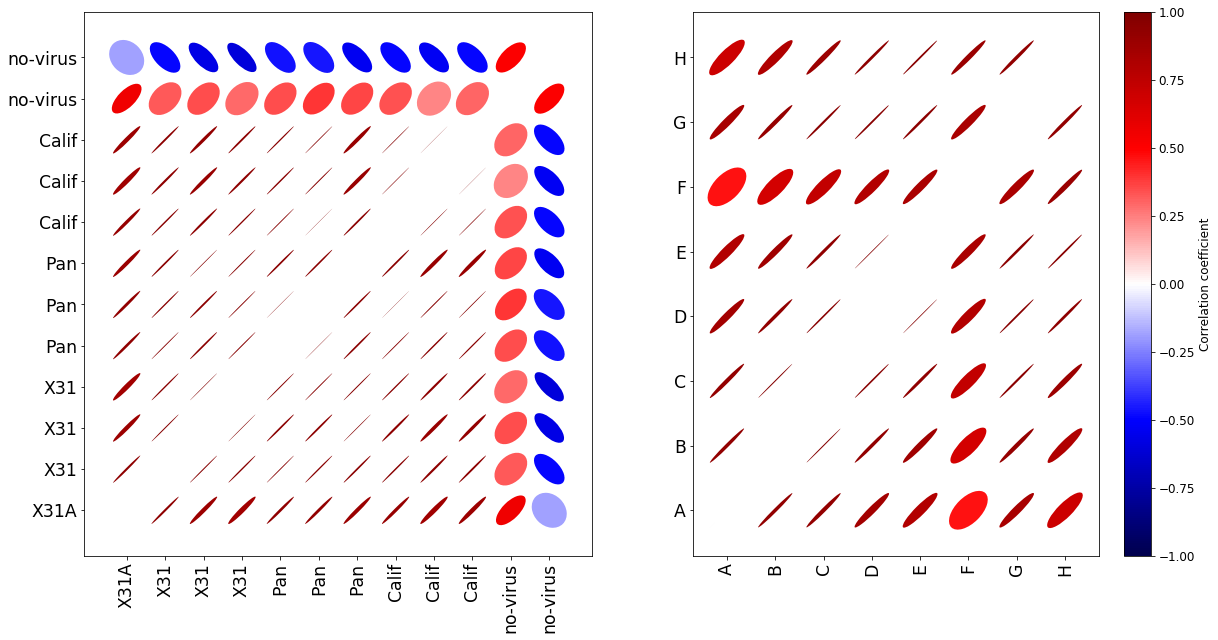

In [202]:

data = output.T.corr()
f, (ax, ax2) = plt.subplots(1, 2,figsize=(20,10))
m = plot_corr_ellipses(data, ax=ax, cmap='seismic',clim=[-1, 1])
ax.margins(0.1)

m = plot_corr_ellipses(output.corr(), ax=ax2, cmap='seismic',clim=[-1, 1])
cb = f.colorbar(m)
cb.ax.tick_params(labelsize="large") 

cb.set_label('Correlation coefficient',fontsize="large")
ax2.margins(0.1)



plt.show()

In [203]:
print(unique_virus_output)

             0        1        2        3       4        5        6        7  \
virus                                                                          
X31    1654.00  2058.75  4591.25  2773.50  151.75   566.00   616.00  3911.25   
H1      529.50   881.75  2581.25  2442.25  577.50  1445.50  1731.50  2900.00   
H5     1008.25  2178.25  2916.00  3364.50  494.00   803.50   709.50  1351.25   
H7     1368.25  1970.00  3967.50  3759.75  165.75   642.25   512.75  1840.25   
Vi       98.50   396.00   552.25   602.00  173.00   480.50   393.50   714.75   
NY      149.75   299.00   686.00   586.00   94.50   224.00   195.25   227.75   

             8  
virus           
X31     403.75  
H1     1356.50  
H5     1785.00  
H7      664.75  
Vi      456.00  
NY      349.75  


In [204]:
#make mean data for viruses
data=[]
for virus in output.index.unique():
    if len(output.loc[virus].shape) == 1:
        data.append(output.loc[virus].values)
    else:
        data.append(output.loc[virus].mean().values)
unique_virus_output=pd.DataFrame(data,output.index.unique())

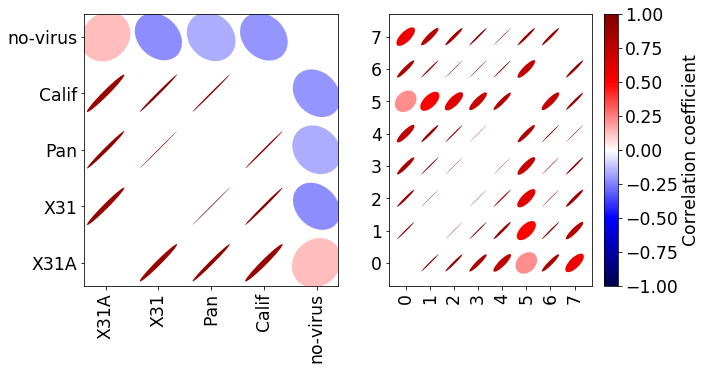

In [205]:

data = unique_virus_output.T.corr()
f, (ax, ax2) = plt.subplots(1, 2,figsize=(10,5.0))
m = plot_corr_ellipses(data, ax=ax, cmap='seismic',clim=[-1, 1])
ax.margins(0.1)

m = plot_corr_ellipses(unique_virus_output.corr(), ax=ax2, cmap='seismic',clim=[-1, 1])
cb = f.colorbar(m)
cb.ax.tick_params(labelsize="xx-large") 

cb.set_label('Correlation coefficient',fontsize="xx-large")
ax2.margins(0.1)
f.savefig("./results/{}_corr_matrix_plot.png".format(data_id),bbox_inches='tight')
plt.show()